In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
# Loading MNIST data
"""
Load the MNIST dataset into numpy arrays
Author: Alexandre Drouin
License: BSD
"""
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST data/", one_hot=True)
X_train = np.vstack([img.reshape((28, 28)) for img in mnist.train.images])
Y_train = mnist.train.labels
X_test = np.vstack([img.reshape(28, 28) for img in mnist.test.images])
Y_test = mnist.test.labels
del mnist

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting MNIST data/train-images-idx3-ubyte.gz
Extracting

Instructions for updating:
Please use tf.one_hot on tensors.


 MNIST data/train-labels-idx1-ubyte.gz
Extracting MNIST data/t10k-images-idx3-ubyte.gz
Extracting

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


 MNIST data/t10k-labels-idx1-ubyte.gz


In [3]:
# printing the data shape

print("Shape of x train",X_train.shape)
print("Shape of y test",Y_train.shape)
print("Shape of x train",X_test.shape)
print("Shape of y test",Y_test.shape)

Shape of x train (1540000, 28)
Shape of y test (55000, 10)
Shape of x train (280000, 28)
Shape of y test (10000, 10)


In [4]:
# Reshaping the data

X_train = np.reshape(X_train,(-1,784))
Y_train = np.reshape(Y_train,(-1,10))
X_test = np.reshape(X_test,(-1,784))
Y_test = np.reshape(Y_test,(-1,10))
print("Shape of x train",X_train.shape)
print("Shape of y train",Y_train.shape)
print("Shape of x test",X_test.shape)
print("Shape of y test",Y_test.shape)

Shape of x train (55000, 784)
Shape of y train (55000, 10)
Shape of x test (10000, 784)
Shape of y test (10000, 10)


In [5]:
# Two Layer Neural Network
class TwoLayerNet(object):
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        #initializing parameters
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    # Forward Pass, Backward pass , loss calculation
    def loss(self, X_train, Y_train, reg=0.0):
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X_train.shape

        # forward pass
        scores = None
        z1 = X_train.dot(W1) + b1 # Input - Hidden
        a1 = np.maximum(0, z1) # ReLU
        scores = a1.dot(W2) + b2

        # Applying softmax
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 

        # Compute the loss
        loss = None
        correct_logprobs = -np.log(probs[range(N), np.argmax(Y_train)])
        data_loss = np.sum(correct_logprobs) / N
        reg_loss = 0.5 * reg * np.sum(W1 * W1) + 0.5 * reg * np.sum(W2 * W2)
        loss = data_loss + reg_loss

        # Backward pass
        # compute gradients
        grads = {}
        dscores = probs
        dscores[range(N),np.argmax(Y_train)] -= 1
        dscores /= N

        # W2 and b2
        grads['W2'] = np.dot(a1.T, dscores)
        grads['b2'] = np.sum(dscores, axis=0)
        
        # next backpropagation into hidden layer
        dhidden = np.dot(dscores, W2.T)
        
        # backprop the ReLU non-linearity
        dhidden[a1 <= 0] = 0
        
        # Backpropagation into W1,b1
        grads['W1'] = np.dot(X_train.T, dhidden)
        grads['b1'] = np.sum(dhidden, axis=0)

        # add regularization to gradient
        grads['W2'] += reg * W2
        grads['W1'] += reg * W1

        return loss, grads
    
    # stochastic gradient Descent update
    def sgd(self,X_train,Y_train,l_rate = 0.01):
        loss,grads = self.loss(X_train,Y_train)
            
        # Updating Parameters (weights and biases)
        self.params['W1'] = self.params['W1'] - (l_rate * grads['W1'])
        self.params['b1'] = self.params['b1'] - (l_rate * grads['b1'])
        self.params['W2'] = self.params['W2'] - (l_rate * grads['W2'])
        self.params['b2'] = self.params['b2'] - (l_rate * grads['b2'])
        return loss
    
    # Momentum update
    def momentum(self,X_train,Y_train,l_rate = 0.01,alpha = 0.75):
        loss,grads = self.loss(X_train,Y_train)
        
        v = {} # velocity
        for i in range(2):
            v['W'+ str(i+1)] = np.zeros((self.params['W'+str(i+1)].shape[0],self.params['W'+str(i+1)].shape[1]))
            v['b'+ str(i+1)] = np.zeros(self.params['b'+str(i+1)].shape[0])
        
        # momentum update
        for i in range(2):
            v['W'+str(i+1)] = (alpha * v['W'+str(i+1)]) - (l_rate * grads['W'+str(i+1)])
            v['b'+str(i+1)] = (alpha * v['b'+str(i+1)]) - (l_rate * grads['b'+str(i+1)])
    
        # Updating Parameters (weights and biases)
        for i in range(2):
            self.params['W'+ str(i+1)] = self.params['W'+ str(i+1)] + v['W'+ str(i+1)]
            self.params['b'+ str(i+1)] = self.params['b'+ str(i+1)] + v['b'+ str(i+1)]
            
        return loss
    
    # Nesterov update
    def nesterov(self,X_train,Y_train,l_rate = 0.01,alpha = 0.75):
            
        v = {} # velocity
        for i in range(2):
            v['W'+ str(i+1)] = np.zeros((self.params['W'+str(i+1)].shape[0],self.params['W'+str(i+1)].shape[1]))
            v['b'+ str(i+1)] = np.zeros(self.params['b'+str(i+1)].shape[0])
            
        for i in range(2):
            self.params['W'+ str(i+1)] = self.params['W'+ str(i+1)] + (alpha * v['W'+ str(i+1)])
            self.params['b'+ str(i+1)] = self.params['b'+ str(i+1)] + (alpha * v['b'+ str(i+1)])
            
        loss,grads = self.loss(X_train,Y_train)
        
        # nesterov update
        for i in range(2):
            v['W'+str(i+1)] = (alpha * v['W'+str(i+1)]) - (l_rate * grads['W'+str(i+1)])
            v['b'+str(i+1)] = (alpha * v['b'+str(i+1)]) - (l_rate * grads['b'+str(i+1)])
    
        # Updating Parameters (weights and biases)
        for i in range(2):
            self.params['W'+ str(i+1)] = self.params['W'+ str(i+1)] + v['W'+ str(i+1)]
            self.params['b'+ str(i+1)] = self.params['b'+ str(i+1)] + v['b'+ str(i+1)]
            
        return loss
    
    # Adagrad update
    def adagrad(self,X_train,Y_train,l_rate = 0.01,alpha = 0.75,delta = 1e-7):
        
        loss,grads = self.loss(X_train,Y_train)
        
        theta = {} # Delta theta initialization
        for i in range(2):
            theta['W'+ str(i+1)] = np.zeros((self.params['W'+str(i+1)].shape[0],self.params['W'+str(i+1)].shape[1]))
            theta['b'+ str(i+1)] = np.zeros(self.params['b'+str(i+1)].shape[0])
        
        r = {} # Gradient accumulation variable
        # Gradient accumulation variable initialization
        for i in range(2):
            r['W'+ str(i+1)] = np.zeros((self.params['W'+str(i+1)].shape[0],self.params['W'+str(i+1)].shape[1]))
            r['b'+ str(i+1)] = np.zeros(self.params['b'+str(i+1)].shape[0])
            
        # Accumulate squared gradient
        for i in range(2):
            r['W'+str(i+1)] += np.multiply(grads['W'+str(i+1)],grads['W'+str(i+1)])
            r['b'+str(i+1)] += np.multiply(grads['b'+str(i+1)],grads['b'+str(i+1)])
        
        # Computing update
        for i in range(2):
            theta['W'+ str(i+1)] = np.multiply(-(l_rate / (delta + np.sqrt(r['W'+str(i+1)]))),grads['W'+str(i+1)])
            theta['b'+ str(i+1)] = np.multiply(-(l_rate / (delta + np.sqrt(r['b'+str(i+1)]))),grads['b'+str(i+1)])
            
        # Updating Parameters (weights and biases)
        for i in range(2):
            self.params['W'+ str(i+1)] = self.params['W'+ str(i+1)] + theta['W'+ str(i+1)]
            self.params['b'+ str(i+1)] = self.params['b'+ str(i+1)] + theta['b'+ str(i+1)]
            
        return loss
    
    # RMSProp update
    def RMSProp(self,X_train,Y_train,l_rate = 0.01,delta = 1e-6, decay = 0.9):
        
        loss,grads = self.loss(X_train,Y_train)
        
        theta = {} # Delta theta initialization
        for i in range(2):
            theta['W'+ str(i+1)] = np.zeros((self.params['W'+str(i+1)].shape[0],self.params['W'+str(i+1)].shape[1]))
            theta['b'+ str(i+1)] = np.zeros(self.params['b'+str(i+1)].shape[0])
        
        r = {} # Gradient accumulation variable
        # Gradient accumulation variable initialization
        for i in range(2):
            r['W'+ str(i+1)] = np.zeros((self.params['W'+str(i+1)].shape[0],self.params['W'+str(i+1)].shape[1]))
            r['b'+ str(i+1)] = np.zeros(self.params['b'+str(i+1)].shape[0])
            
        # Accumulate squared gradient
        for i in range(2):
            r['W'+str(i+1)] = (decay * r['W'+str(i+1)]) + ((1 - decay) * np.multiply(grads['W'+str(i+1)],grads['W'+str(i+1)]))
            r['b'+str(i+1)] = (decay * r['b'+str(i+1)]) + ((1 - decay) * np.multiply(grads['b'+str(i+1)],grads['b'+str(i+1)]))
        
        # Computing update
        for i in range(2):
            theta['W'+ str(i+1)] = -l_rate * np.multiply((1/( delta + np.sqrt(r['W'+str(i+1)]))),grads['W'+str(i+1)])
            theta['b'+ str(i+1)] = -l_rate * np.multiply((1/( delta + np.sqrt(r['b'+str(i+1)]))),grads['b'+str(i+1)])
            
        # Updating Parameters (weights and biases)
        for i in range(2):
            self.params['W'+ str(i+1)] = self.params['W'+ str(i+1)] + theta['W'+ str(i+1)]
            self.params['b'+ str(i+1)] = self.params['b'+ str(i+1)] + theta['b'+ str(i+1)]
            
        return loss
    
    # ADAM update
    def ADAM(self,X_train,Y_train,t,l_rate = 0.001,delta = 1e-8, decay1 = 0.9,decay2 = 0.999):
        
        theta = {} # Delta theta initialization
        for i in range(2):
            theta['W'+ str(i+1)] = np.zeros((self.params['W'+str(i+1)].shape[0],self.params['W'+str(i+1)].shape[1]))
            theta['b'+ str(i+1)] = np.zeros(self.params['b'+str(i+1)].shape[0])
        
        s = {} # First Moment variable
        # First Moment variable initialization
        for i in range(2):
            s['W'+ str(i+1)] = np.zeros((self.params['W'+str(i+1)].shape[0],self.params['W'+str(i+1)].shape[1]))
            s['b'+ str(i+1)] = np.zeros(self.params['b'+str(i+1)].shape[0])
        
        r = {} # Second Moment variable
        # Second Moment variable initialization
        for i in range(2):
            r['W'+ str(i+1)] = np.zeros((self.params['W'+str(i+1)].shape[0],self.params['W'+str(i+1)].shape[1]))
            r['b'+ str(i+1)] = np.zeros(self.params['b'+str(i+1)].shape[0])
            
        loss,grads = self.loss(X_train,Y_train)
        
        # First Moment estimate
        for i in range(2):
            s['W'+str(i+1)] = (decay1 * s['W'+str(i+1)]) + ((1 - decay1) * grads['W'+str(i+1)])
            s['b'+str(i+1)] = (decay1 * s['b'+str(i+1)]) + ((1 - decay1) * grads['b'+str(i+1)])
            
        # Second Moment estimate
        for i in range(2):
            r['W'+str(i+1)] = (decay2 * r['W'+str(i+1)]) + ((1 - decay2) * np.multiply(grads['W'+str(i+1)],grads['W'+str(i+1)]))
            r['b'+str(i+1)] = (decay2 * r['b'+str(i+1)]) + ((1 - decay2) * np.multiply(grads['b'+str(i+1)],grads['b'+str(i+1)]))
        
        s_hat = {} # Correct Bias First Moment variable
        # Correct bias in First Moment variable initialization
        for i in range(2):
            s_hat['W'+ str(i+1)] = np.zeros((self.params['W'+str(i+1)].shape[0],self.params['W'+str(i+1)].shape[1]))
            s_hat['b'+ str(i+1)] = np.zeros(self.params['b'+str(i+1)].shape[0])
            
        r_hat = {} # Correct Bias in second Moment variable
        # Correct Bias in second Moment variable initialization
        for i in range(2):
            r_hat['W'+ str(i+1)] = np.zeros((self.params['W'+str(i+1)].shape[0],self.params['W'+str(i+1)].shape[1]))
            r_hat['b'+ str(i+1)] = np.zeros(self.params['b'+str(i+1)].shape[0])
        
        # correct bias in first moment
        for i in range(2):
            s_hat['W'+ str(i+1)] = (s['W'+ str(i+1)] / (1 - (decay1**t)))
            s_hat['b'+ str(i+1)] = (s['b'+ str(i+1)] / (1 - (decay2**t)))
            
        # correct bias in second moment
        for i in range(2):
            r_hat['W'+ str(i+1)] = (r['W'+ str(i+1)] / (1 - (decay1**t)))
            r_hat['b'+ str(i+1)] = (r['b'+ str(i+1)] / (1 - (decay2**t)))
            
        # Computing update
        for i in range(2):
            theta['W'+ str(i+1)] = -((l_rate * s_hat['W'+ str(i+1)]) / (delta + np.sqrt(r_hat['W'+str(i+1)])))
            theta['b'+ str(i+1)] = -((l_rate * s_hat['b'+ str(i+1)]) / (delta + np.sqrt(r_hat['b'+str(i+1)])))
            
        # Updating Parameters (weights and biases)
        for i in range(2):
            self.params['W'+ str(i+1)] = self.params['W'+ str(i+1)] + theta['W'+ str(i+1)]
            self.params['b'+ str(i+1)] = self.params['b'+ str(i+1)] + theta['b'+ str(i+1)]
            
        return loss

In [7]:
input_size = 784
hidden_size = 1000
output_size = 10
l_sgd = []
NN = TwoLayerNet(input_size,hidden_size,output_size) # Calling Neural Network

# Displaying Loss 
for i in range(100):
    loss = NN.sgd(X_train,Y_train)
    if i % 10 == 0:
        print("loss in %d/100 iterations : " %(i+1),loss)
    l_sgd = np.append(l_sgd,loss)

loss in 1/100 iterations :  2.30258165879
loss in 11/100 iterations :  2.21341667864
loss in 21/100 iterations :  2.12611017952
loss in 31/100 iterations :  2.04066345174
loss in 41/100 iterations :  1.95689670133
loss in 51/100 iterations :  1.8741381869
loss in 61/100 iterations :  1.79041140541
loss in 71/100 iterations :  1.70038349262
loss in 81/100 iterations :  1.59057135461
loss in 91/100 iterations :  1.43039300588


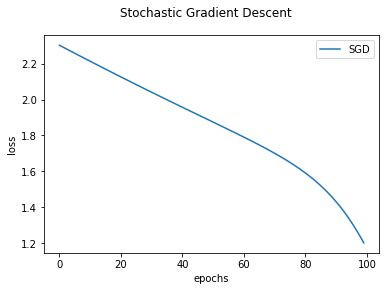

In [8]:
# plotting Stochastic Gradient Loss

iter = range(100)
plt.plot(iter,l_sgd,label = 'SGD')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.suptitle('Stochastic Gradient Descent')
plt.legend()
plt.show()

In [9]:
input_size = 784
hidden_size = 1000
output_size = 10
l_m = []
NN = TwoLayerNet(input_size,hidden_size,output_size) # Calling Neural Network

# Displaying Loss 
for i in range(100):
    loss = NN.momentum(X_train,Y_train)
    if i % 10 == 0:
        print("loss in %d/100 iterations : " %(i+1),loss)
    l_m = np.append(l_m,loss)

loss in 1/100 iterations :  2.30258598156
loss in 11/100 iterations :  2.21342087528
loss in 21/100 iterations :  2.12611918712
loss in 31/100 iterations :  2.04068872597
loss in 41/100 iterations :  1.95696996503
loss in 51/100 iterations :  1.87434641825
loss in 61/100 iterations :  1.7909895924
loss in 71/100 iterations :  1.70195111146
loss in 81/100 iterations :  1.59467361877
loss in 91/100 iterations :  1.44039469371


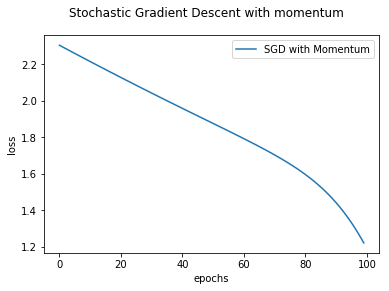

In [10]:
# plotting Stochastic Gradient with momentum Loss

iter = range(100)
plt.plot(iter,l_m,label = 'SGD with Momentum')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.suptitle('Stochastic Gradient Descent with momentum')
plt.legend()
plt.show()

In [6]:
input_size = 784
hidden_size = 1000
output_size = 10
l_n = []
NN = TwoLayerNet(input_size,hidden_size,output_size) # Calling Neural Network

# Displaying Loss 
for i in range(100):
    loss = NN.nesterov(X_train,Y_train)
    if i % 10 == 0:
        print("loss in %d/100 iterations : " %(i+1),loss)
    l_n = np.append(l_n,loss)

loss in 1/100 iterations :  2.30258461226
loss in 11/100 iterations :  2.21341643759
loss in 21/100 iterations :  2.12610595558
loss in 31/100 iterations :  2.04064985568
loss in 41/100 iterations :  1.95685757689
loss in 51/100 iterations :  1.87402776771
loss in 61/100 iterations :  1.79010502675
loss in 71/100 iterations :  1.69955336383
loss in 81/100 iterations :  1.58840276503
loss in 91/100 iterations :  1.42513139182


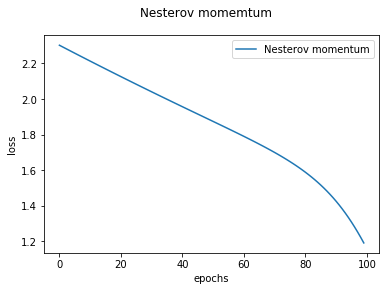

In [7]:
# plotting Nesterov momentum Loss

iter = range(100)
plt.plot(iter,l_n,label = 'Nesterov momentum')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.suptitle('Nesterov momemtum')
plt.legend()
plt.show()

In [13]:
input_size = 784
hidden_size = 1000
output_size = 10
l_g = []
NN = TwoLayerNet(input_size,hidden_size,output_size) # Calling Neural Network

# Displaying Loss 
for i in range(100):
    loss = NN.adagrad(X_train,Y_train)
    if i % 10 == 0:
        print("loss in %d/100 iterations : " %(i+1),loss)
    l_g = np.append(l_g,loss)

loss in 1/100 iterations :  2.30258356891
loss in 11/100 iterations :  6.87250503264e-09
loss in 21/100 iterations :  3.33265401119e-09
loss in 31/100 iterations :  2.20626186052e-09
loss in 41/100 iterations :  1.650161138e-09
loss in 51/100 iterations :  1.31827263406e-09
loss in 61/100 iterations :  1.09761076192e-09
loss in 71/100 iterations :  9.40236650138e-10
loss in 81/100 iterations :  8.22316911109e-10
loss in 91/100 iterations :  7.30657546636e-10


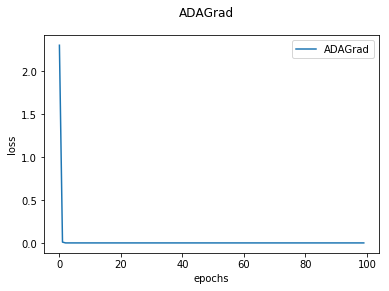

In [14]:
# plotting ADAGrad Loss

iter = range(100)
plt.plot(iter,l_g,label = 'ADAGrad')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.suptitle('ADAGrad')
plt.legend()
plt.show()

In [15]:
input_size = 784
hidden_size = 1000
output_size = 10
l_r = []
NN = TwoLayerNet(input_size,hidden_size,output_size) # Calling Neural Network

# Displaying Loss 
for i in range(100):
    loss = NN.RMSProp(X_train,Y_train)
    if i % 10 == 0:
        print("loss in %d/100 iterations : " %(i+1),loss)
    l_r = np.append(l_r,loss)

loss in 1/100 iterations :  2.30258501015
loss in 11/100 iterations :  1.77074298147e-09
loss in 21/100 iterations :  1.71826672086e-09
loss in 31/100 iterations :  1.66882043188e-09
loss in 41/100 iterations :  1.62214854317e-09
loss in 51/100 iterations :  1.57802347538e-09
loss in 61/100 iterations :  1.5362419075e-09
loss in 71/100 iterations :  1.49662162639e-09
loss in 81/100 iterations :  1.4589988557e-09
loss in 91/100 iterations :  1.42322597655e-09


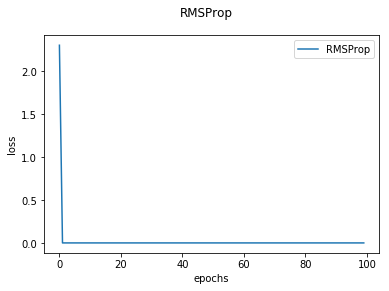

In [16]:
# plotting RMSProp Loss

iter = range(100)
plt.plot(iter,l_r,label = 'RMSProp')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.suptitle('RMSProp')
plt.legend()
plt.show()

In [17]:
input_size = 784
hidden_size = 1000
output_size = 10
l_adam = []
NN = TwoLayerNet(input_size,hidden_size,output_size) # Calling Neural Network
t = 0
# Displaying Loss 
for i in range(100):
    loss = NN.ADAM(X_train,Y_train,t = i+1)
    if i % 10 == 0:
        print("loss in %d/100 iterations : " %(i+1),loss)
    l_adam = np.append(l_adam,loss)

loss in 1/100 iterations :  2.30258505391
loss in 11/100 iterations :  1.28813046338e-08
loss in 21/100 iterations :  8.19934093847e-09
loss in 31/100 iterations :  6.37231951698e-09
loss in 41/100 iterations :  5.30502376191e-09
loss in 51/100 iterations :  4.57796274318e-09
loss in 61/100 iterations :  4.04151526269e-09
loss in 71/100 iterations :  3.62574657963e-09
loss in 81/100 iterations :  3.29239558546e-09
loss in 91/100 iterations :  3.01831581189e-09


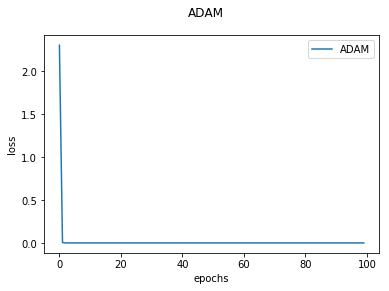

In [18]:
# plotting ADAM Loss

iter = range(100)
plt.plot(iter,l_adam,label = 'ADAM')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.suptitle('ADAM')
plt.legend()
plt.show()

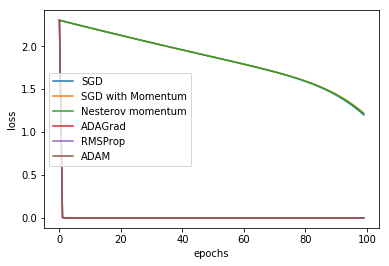

In [19]:

plt.plot(iter,l_sgd,label = 'SGD')
plt.plot(iter,l_m,label = 'SGD with Momentum')
plt.plot(iter,l_n,label = 'Nesterov momentum')
plt.plot(iter,l_g,label = 'ADAGrad')
plt.plot(iter,l_r,label = 'RMSProp')
plt.plot(iter,l_adam,label = 'ADAM')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()